In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
# Load datasets
depressed_df = pd.read_csv('/content/drive/MyDrive/clean_depressed.csv', dtype={'tweet': str})
non_depressed_df = pd.read_csv('/content/drive/MyDrive/clean_non_d.csv', dtype={'tweet': str})

In [ ]:
# Add a 'label' column to each DataFrame
depressed_df['label'] = 1  # Set label to 1 for depressed tweets
non_depressed_df['label'] = 0  # Set label to 0 for non-depressed tweets

# Combine DataFrames using 'append'
df = pd.concat([depressed_df, non_depressed_df], ignore_index=True)

# Split data into features (tweets) and labels
tweets = df['tweet'].to_list()  # Convert to a list of strings
labels = df['label'].values

In [ ]:
# Split data into train, validation, and test sets
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    tweets, labels, test_size=0.2, random_state=42)
train_tweets, validation_tweets, train_labels, validation_labels = train_test_split(
    train_tweets, train_labels, test_size=0.25, random_state=42)

# Ensure all tweets are strings
train_tweets = [str(tweet) for tweet in train_tweets]
validation_tweets = [str(tweet) for tweet in validation_tweets] # convert validation_tweets to strings
test_tweets = [str(tweet) for tweet in test_tweets] # convert test_tweets to strings

# Tokenize the tweets
tokenizer = Tokenizer(num_words=10000)  # Adjust num_words as needed
tokenizer.fit_on_texts(train_tweets)

# Convert tweets to sequences of indices
train_sequences = tokenizer.texts_to_sequences(train_tweets)
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
test_sequences = tokenizer.texts_to_sequences(test_tweets)

In [ ]:
# Pad sequences to the same length
max_sequence_length = 100  # Adjust as needed
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length)
validation_padded = pad_sequences(validation_sequences, maxlen=max_sequence_length)
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Create the Bi-directional LSTM model
model = Sequential()
model.add(Embedding(10000, 128))  # Adjust embedding size
model.add(LSTM(128, return_sequences=True, dropout=0.2))  # Adjust LSTM units
model.add(LSTM(64, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_padded, train_labels, epochs=10, validation_data=(validation_padded, validation_labels))

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 48s 302ms/step - accuracy: 0.7142 - loss: 0.5547 - val_accuracy: 0.8044 - val_loss: 0.4175
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.8891 - loss: 0.2748 - val_accuracy: 0.8411 - val_loss: 0.3540
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 80s 275ms/step - accuracy: 0.9332 - loss: 0.1713 - val_accuracy: 0.8642 - val_loss: 0.3385
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.9704 - loss: 0.0884 - val_accuracy: 0.8636 - val_loss: 0.4219
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 83s 294ms/step - accuracy: 0.9742 - loss: 0.0651 - val_accuracy: 0.8546 - val_loss: 0.5021
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 290ms/step - accuracy: 0.9842 - loss: 0.0475 - val_accuracy: 0.8591 - val_loss: 0.4574
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 81s 281ms/step - accuracy: 0.9868 - loss: 0.0393 - val_accuracy: 0.8314 - val_loss: 0.6008
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 82s 280ms/step - accuracy: 0.9868 - loss: 0

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print('Test accuracy:', accuracy)

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.8587 - loss: 0.6306
Test accuracy: 0.8590733408927917


In [ ]:
# Predict on new tweets (example)
new_tweet = ["I feel so sad and tired all the time."]
new_sequences = tokenizer.texts_to_sequences(new_tweet)
new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length)
prediction = model.predict(new_padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


In [ ]:
prediction

array([[0.9998305]], dtype=float32)

In [ ]:
if prediction[0][0] > 0.5:
    print("Predicted: Depressed")
else:
    print("Predicted: Non-Depressed")

Predicted: Depressed


In [ ]:
# Predict on the test set (from the CSV files)
predictions = model.predict(test_padded)

# Create a new DataFrame to store predictions
results_df = pd.DataFrame({'tweet': test_tweets, 'predicted_label': predictions.flatten()})

# Interpret predictions (0 = non-depressed, 1 = depressed)
results_df['predicted_label'] = np.where(results_df['predicted_label'] > 0.5, 1, 0)

# Print or save the results
print(results_df[20:30])
results_df.to_csv('prediction_results.csv', index=False)  # Save results to a CSV fi

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step
                                                tweet  predicted_label
20  much respect to whoever decide the nail file u...                0
21  due to the coronavirus a group be urge the nca...                0
22  join me tonight live for this months spiritual...                0
23  if all your go to do be correct my grammar the...                1
24  the only way to truly find out if it will work...                0
25  fake a smile be way easier then explain what b...                1
26  i let you in i let you fuck in and you complet...                1
27        sleep be so hard when you cannot stop think                1
28  when a lyft driver offer you a mint it be good...                0
29  i wish we could use to hide tweet until people...                1


In [ ]:
print(results_df.to_string())

                                                                                                                                                                                                                                                                          tweet  predicted_label
0                                                                                                                                                                                                      it be okay just leave me alone i do not want to talk to anyone right now                1
1                                                                                                                                                                                                                                                      my shit come out tuesday                1
2              most people think it be stupid for apps to add stories i think the opposite way more company should launch stories it 

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and capture the history
history = model.fit(train_padded, train_labels, epochs=10, validation_data=(validation_padded, validation_labels))

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 304ms/step - accuracy: 0.7088 - loss: 0.5523 - val_accuracy: 0.8423 - val_loss: 0.3607
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 78s 275ms/step - accuracy: 0.8874 - loss: 0.2593 - val_accuracy: 0.8552 - val_loss: 0.3439
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.9419 - loss: 0.1581 - val_accuracy: 0.8571 - val_loss: 0.3414
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 38s 262ms/step - accuracy: 0.9608 - loss: 0.1046 - val_accuracy: 0.8623 - val_loss: 0.3645
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.9800 - loss: 0.0623 - val_accuracy: 0.8578 - val_loss: 0.4645
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.9885 - loss: 0.0415 - val_accuracy: 0.8591 - val_loss: 0.5152
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.9868 - loss: 0.0349 - val_accuracy: 0.8533 - val_loss: 0.4943
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 271ms/step - accuracy: 0.9871 - loss: 0

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print('Test accuracy:', accuracy)

# Predict on the test set
predictions = model.predict(test_padded)
predicted_labels = np.where(predictions > 0.5, 1, 0)

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8560 - loss: 0.5940
Test accuracy: 0.8674388527870178
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step


In [ ]:
# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)
confusion_mat = confusion_matrix(test_labels, predicted_labels)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print('Confusion Matrix:\n', confusion_mat)


Accuracy: 0.8674
Precision: 0.8381
Recall: 0.8354
F1-score: 0.8368
Confusion Matrix:
 [[820 102]
 [104 528]]


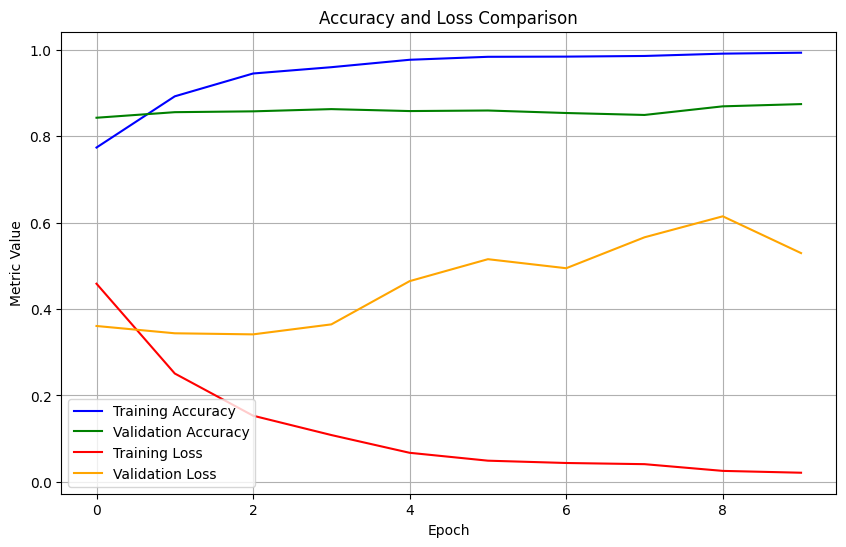

In [ ]:
# Create combined accuracy and loss comparison graph
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')

# Loss plot
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Accuracy and Loss Comparison')
plt.legend()
plt.grid(True)  # Add grid lines
plt.show()

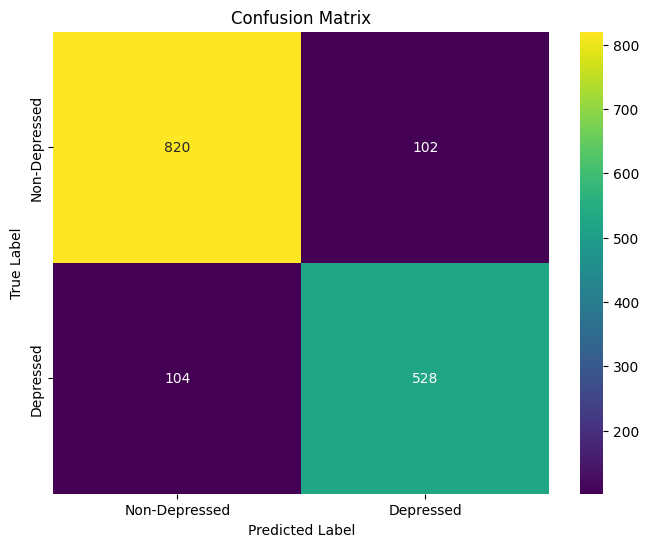

In [ ]:
# Confusion Matrix Visualization (Colorful)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="viridis",  # Use 'viridis' colormap
            xticklabels=['Non-Depressed', 'Depressed'],
            yticklabels=['Non-Depressed', 'Depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()